<a href="https://colab.research.google.com/github/rishitha957/nlp-selfsup-hw1/blob/main/Profiling_cpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q torchstat

In [5]:
import torch
import torch.nn.functional as F
import time
import tracemalloc
import numpy as np
import pickle
import pandas as pd
import psutil
import os

In [3]:
input_lengths = [10, 100, 1000, 5000, 10000, 20000, 50000]

d = 100
dq = 16
dv = 32

flops, memory_usage, wallclock_time = [], [], []
flops_std_error, memory_usage_std_error, wallclock_time_std_error = [], [], []

In [4]:
flops_file = 'flops.pkl'
memory_file = 'memory.pkl'
time_file = 'time.pkl'
flops_error_file = 'flops_error.pkl'
memory_error_file = 'memory_error.pkl'
time_error_file = 'time_error.pkl'


In [2]:
def save_results(file_name, data):
    with open(file_name, 'wb') as f:
        pickle.dump(data, f)

def load_results(file_name):
    try:
        with open(file_name, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        return []

In [31]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [32]:
print(device)

cpu


In [34]:
from typing_extensions import final
def profile(input_length):
    x = torch.randint(0, input_length, (input_length,), dtype=torch.int32).to(device)
    W_query = torch.rand(d, dq, dtype = torch.float16, device = device)
    W_key = torch.rand(d, dq, dtype = torch.float16, device = device)
    W_value = torch.rand(d, dv, dtype = torch.float16, device = device)

    embed = torch.nn.Embedding(input_length, d, dtype=torch.float16, device=device)

    x = embed(x)

    start_time = time.time()

    query = torch.matmul(x, W_query)
    key = torch.matmul(x, W_key)
    value = torch.matmul(x, W_value)

    process = psutil.Process(os.getpid())
    initial_memory = process.memory_info().rss  # in bytes

    sim = torch.matmul(query, key.T)
    attention = F.softmax(sim/dq**0.5, dim=1) # row sum = 1 so dim = 1
    out = torch.matmul(attention, value)

    end_time = time.time()

    final_memory = process.memory_info().rss

    flops_query_key_value = 2 * (input_length * d * dq)
    flops_similarity = 2 * (input_length**2 * dq)
    flops_softmax = input_length**2
    flops_attention_output = 2 * (input_length * input_length * dv)

    total_flops = flops_query_key_value * 3 + flops_similarity + flops_softmax + flops_attention_output

    return total_flops, final_memory - initial_memory, end_time - start_time

In [ ]:
for input_length in input_lengths:
    total_flops, total_peak_memory, total_wallclock_time = [], [], []
    for i in range(3):
        curr_flops, curr_memory, curr_time = profile(input_length)
        total_flops.append(curr_flops)
        total_peak_memory.append(curr_memory)
        total_wallclock_time.append(curr_time)

    mean_flops = np.mean(total_flops)
    mean_memory = np.mean(total_peak_memory)
    mean_time = np.mean(total_wallclock_time)

    std_flops = np.std(total_flops)
    std_memory = np.std(total_peak_memory)
    std_time = np.std(total_wallclock_time)

    std_error_flops = std_flops / np.sqrt(len(total_flops))
    std_error_memory = std_memory / np.sqrt(len(total_peak_memory))
    std_error_time = std_time / np.sqrt(len(total_wallclock_time))

    flops_std_error.append(std_error_flops)
    memory_usage_std_error.append(std_error_memory)
    wallclock_time_std_error.append(std_error_time)

    flops.append(mean_flops)
    memory_usage.append(mean_memory)
    wallclock_time.append(mean_time)

    save_results(flops_file, flops)
    save_results(memory_file, memory_usage)
    save_results(time_file, wallclock_time)
    save_results(flops_error_file, flops_std_error)
    save_results(memory_error_file, memory_usage_std_error)
    save_results(time_error_file, wallclock_time_std_error)

    print(f'Mean FLOPs: {mean_flops} for input length {input_length}')
    print(f'Mean peak memory usage: {mean_memory} for input length {input_length}')
    print(f'Mean wallclock time: {mean_time} for input length {input_length}')
    print()


Mean FLOPs: 105700.0 for input length 10
Mean peak memory usage: 527018.6666666666 for input length 10
Mean wallclock time: 0.018278201421101887 for input length 10

Mean FLOPs: 1930000.0 for input length 100
Mean peak memory usage: 0.0 for input length 100
Mean wallclock time: 0.0022579034169514975 for input length 100

Mean FLOPs: 106600000.0 for input length 1000
Mean peak memory usage: 2315605.3333333335 for input length 1000
Mean wallclock time: 0.11277882258097331 for input length 1000

Mean FLOPs: 2473000000.0 for input length 5000
Mean peak memory usage: 100040704.0 for input length 5000
Mean wallclock time: 2.903242508570353 for input length 5000

Mean FLOPs: 9796000000.0 for input length 10000
Mean peak memory usage: 400007168.0 for input length 10000
Mean wallclock time: 11.305603186289469 for input length 10000

Mean FLOPs: 38992000000.0 for input length 20000
Mean peak memory usage: 1600135168.0 for input length 20000
Mean wallclock time: 54.07713786760966 for input length

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:

data = {
    'flops': load_results(flops_file),
    'memory_usage': load_results(memory_file),
    'wallclock_time': load_results(time_file),
    'flops_std_error': load_results(flops_error_file),
    'memory_usage_std_error': load_results(memory_error_file),
    'wallclock_time_std_error': load_results(time_error_file),
    'input_lengths': input_lengths
}
data = pd.DataFrame(data)


In [7]:
input_lengths = [10, 100, 1000, 5000, 10000, 20000]

In [34]:
def plot_results(measure, measure_std_error, x, label_value):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=data, x=x, y=measure, color='b', label='Mean')
    plt.fill_between(data[x],
                    data[measure] - 10*data[measure_std_error],
                    data[measure] + 10*data[measure_std_error],
                    color='b',
                    alpha=0.2,
                    label='±10 Std Dev')
    plt.xlabel('Input Length')
    plt.ylabel(label_value)
    plt.title(f'{label_value} vs Input Length')
    plt.grid(True)
    plt.legend()
    plt.savefig(f'{label_value}-vs-input-length.png')
    plt.show()

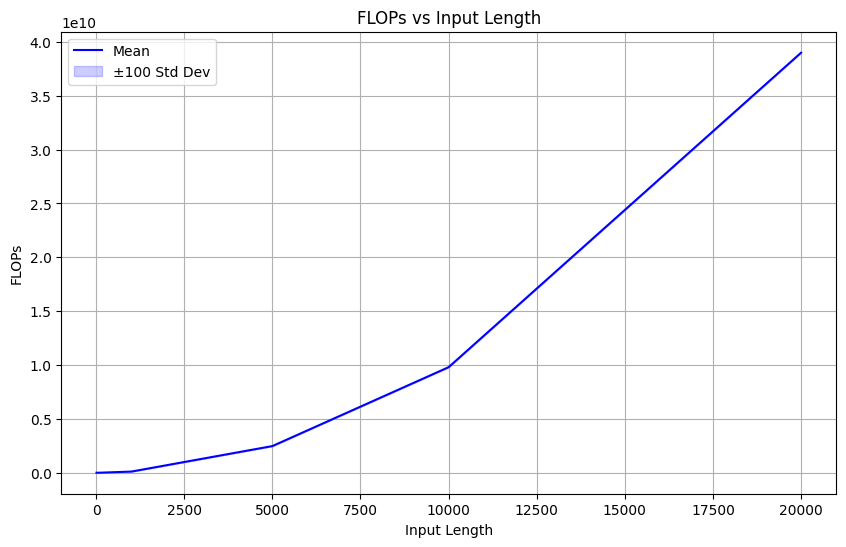

In [28]:
plot_results('flops', 'flops_std_error', 'input_lengths', 'FLOPs')

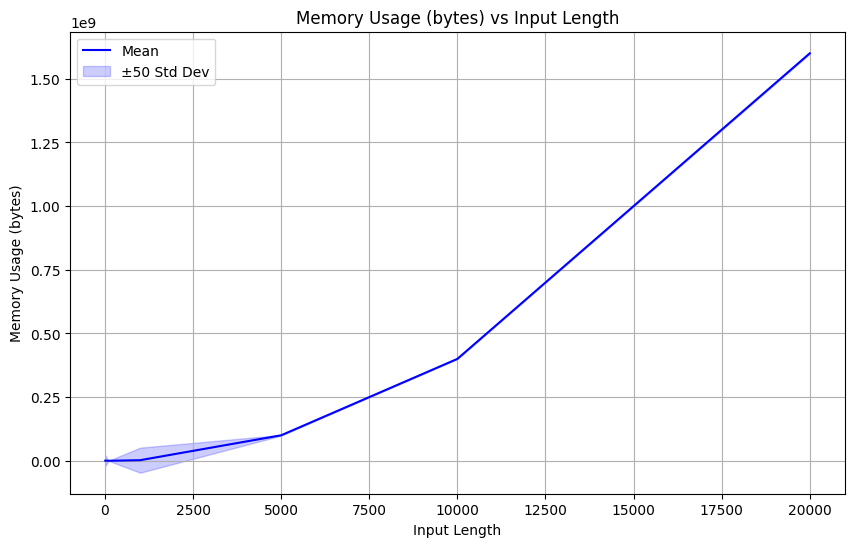

In [32]:
plot_results('memory_usage', 'memory_usage_std_error', 'input_lengths', 'Memory Usage (bytes)')

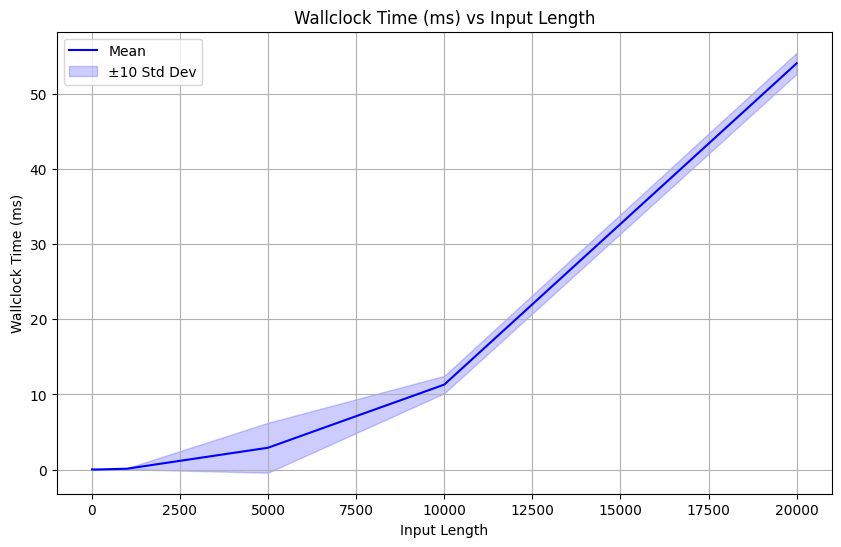

In [35]:
plot_results('wallclock_time', 'wallclock_time_std_error', 'input_lengths', 'Wallclock Time (ms)')